## Implementing a Decision Tree

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier

df= pd.read_csv('./day5_titanic/train.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [2]:
y=df['Survived']
X=df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']]

#### Although a decision tree can handle categorical features and missing data, using the same preprocessing for the sake of comparison with other implemented algorithms. Will compute again to check perforamnce without preprocessing

In [3]:
X_numeric = X[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
X_categorical = X[['Sex','Embarked']]
X_neither = X['Cabin']
X_onehot = pd.get_dummies(X_categorical,['Sex','Embarked']).astype(int)
X_cabin_nonna = X['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
X_encoded0 = pd.merge(X_numeric, X_cabin_nonna,  left_index=True, right_index=True)
X_encoded1 = pd.merge(X_encoded0, X_onehot,  left_index=True, right_index=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded1, y, test_size=0.2, random_state=42, stratify=y
)
from sklearn.impute import SimpleImputer

# Imputer for numeric columns (e.g., Age)
imputer = SimpleImputer(strategy='median')  # or 'mean' if you prefer

# Fit on train, transform train
X_train['Age'] = imputer.fit_transform(X_train[['Age']])

# Transform test using same statistics
X_test['Age'] = imputer.transform(X_test[['Age']])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
X_test.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [5]:
np.unique(X_train['Age'])

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 24.  , 25.  , 26.  , 27.  , 28.  , 28.5 ,
       29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 ,
       35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  , 40.5 , 41.  ,
       42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  ,
       50.  , 51.  , 52.  , 54.  , 55.  , 55.5 , 56.  , 57.  , 58.  ,
       59.  , 60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 66.  , 70.  ,
       70.5 , 71.  , 74.  , 80.  ])

### Performance on sklearns implementation
Hyperparameters: min examples per leaf, max tree depth, min impurity reduction on split
Start at X_train_scaled, X_test_scaled, y_train, y_test and apply decision tree

In [18]:
# ----------------------------
# Import libraries
# ----------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# ----------------------------
# Create and train Decision Tree model
# ----------------------------
# You can tune parameters like max_depth, min_samples_split, etc.
dt_model = DecisionTreeClassifier(random_state=42,max_depth=3)

# Train the model
dt_model.fit(X_train_scaled, y_train)

# ----------------------------
# Make predictions
# ----------------------------
y_train_pred = dt_model.predict(X_train_scaled)
y_test_pred = dt_model.predict(X_test_scaled)

# ----------------------------
# Evaluate accuracy
# ----------------------------
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Decision Tree Train Accuracy: {train_acc:.4f}")
print(f"Decision Tree Test Accuracy:  {test_acc:.4f}")


Decision Tree Train Accuracy: 0.8329
Decision Tree Test Accuracy:  0.7933


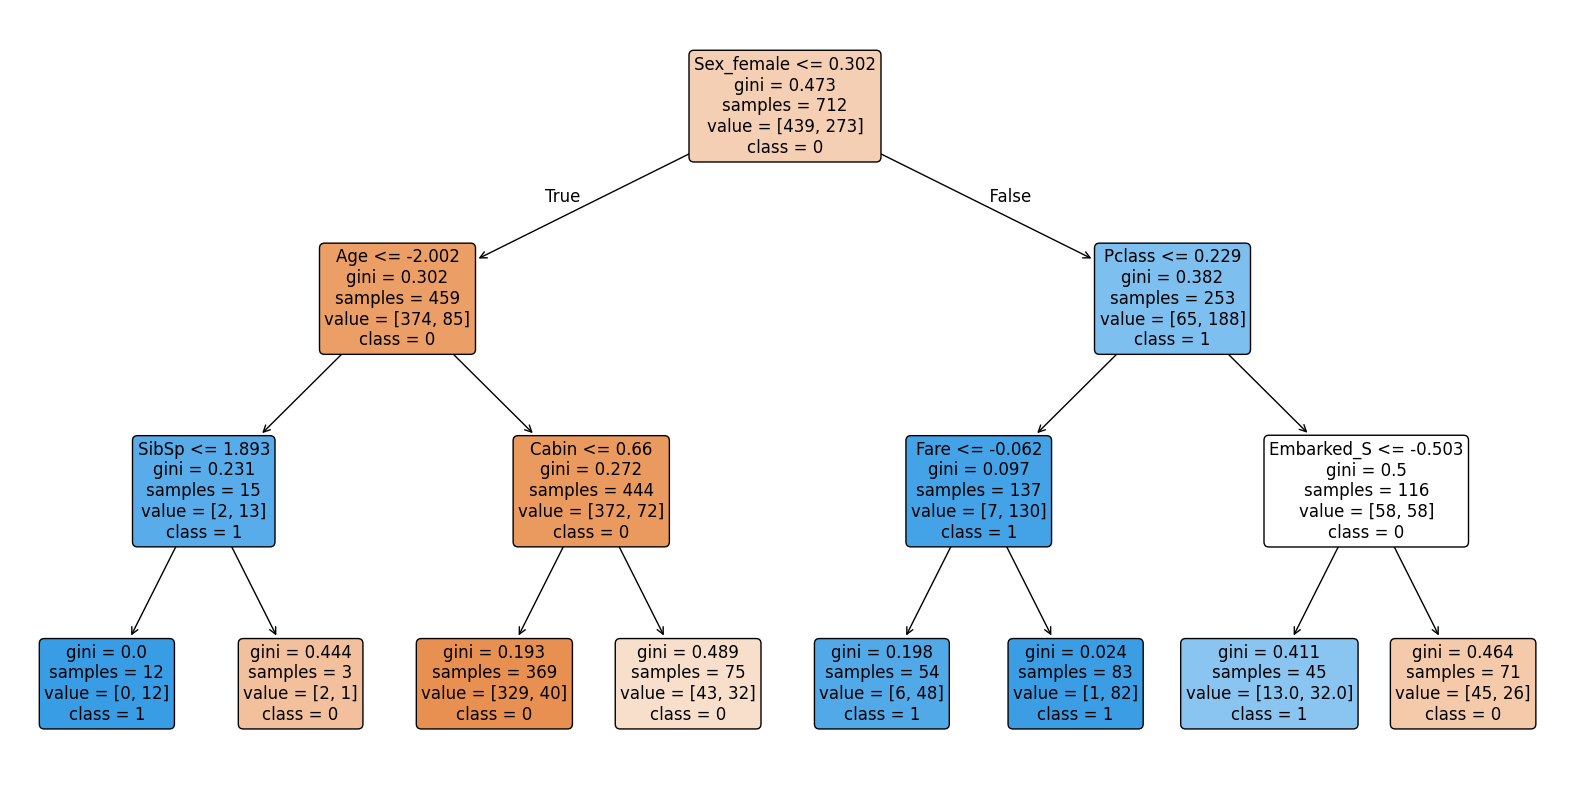

In [19]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))  # adjust size as needed
tree.plot_tree(
    dt_model,                 # your trained Decision Tree
    feature_names=X_train.columns,  # column names
    class_names=['0','1'],    # labels for classes
    filled=True,              # color nodes by class
    rounded=True,             # rounded boxes
    fontsize=12
)
plt.show()


### Implementation from scratch

In [7]:
# Your entropy function
def entropy(y):
    '''
    y is a pandas series. return float value of entropy
    '''
    eps = 1e-9
    n_samples = y.shape[0]
    
    y = np.asarray(y)
    cats, counts = np.unique(y, return_counts=True)
    pi =  (counts/ n_samples) + eps
    pi = pi / sum(pi)
    log_pi = np.log2(pi)
    entropy = np.dot(pi,log_pi)
    return -1 *  entropy

# ------------------------------
# Test cases
# ------------------------------

# 1. Simple binary classification
y1 = pd.Series(['cat', 'cat', 'dog', 'dog', 'dog'])
expected1 = -((2/5)*np.log2(2/5) + (3/5)*np.log2(3/5))
assert abs(entropy(y1) - expected1) < 1e-6, "Test 1 failed"
print("Test 1 passed")

# 2. Uniform distribution
y2 = pd.Series(['a', 'b', 'c', 'd'])
expected2 = -sum([0.25*np.log2(0.25)]*4)  # log2(0.25) = -2
assert abs(entropy(y2) - expected2) < 1e-6, "Test 2 failed"
print("Test 2 passed")

# 3. Single category (entropy should be 0)
y3 = pd.Series(['only', 'only', 'only'])
expected3 = 0
assert abs(entropy(y3) - expected3) < 1e-6, "Test 3 failed"
print("Test 3 passed")

# 4. Numerical labels
y4 = pd.Series([1, 1, 1, 2])
expected4 = -((3/4)*np.log2(3/4) + (1/4)*np.log2(1/4))
assert abs(entropy(y4) - expected4) < 1e-6, "Test 4 failed"
print("Test 4 passed")

# 5. Empty series (entropy should handle gracefully)
y5 = pd.Series([])
try:
    e5 = entropy(y5)
    print("Test 5 output:", e5)
except Exception as ex:
    print("Test 5 passed (handled empty input with exception):", ex)


Test 1 passed
Test 2 passed
Test 3 passed
Test 4 passed
Test 5 output: -0.0


In [ ]:
import pandas as pd
y = pd.Series(['cat', 'cat', 'dog', 'dog', 'dog'])
print(entropy(y))  # Output: ~0.97095

In [8]:
def information_gain(y, y_l, y_r):
    '''
    computes infromation gain when y is split into y_l and y_r
    '''
    y, y_l, y_r = map(np.asarray, (y, y_l, y_r))
    n, n_l, n_r = (arr.shape[0] for arr in (y,y_l,y_r))
    if n_l == 0 or n_r == 0:
        return 0
    
    term1 = entropy(y)
    term2 = (n_l)*entropy(y_l)/(n)
    term3 = (n_r)*entropy(y_r)/(n)
    return term1 - term2 - term3



In [9]:
# ------------------------------
# Test cases
# ------------------------------

# 1. Perfect split (all left are 'cat', all right are 'dog')
y = pd.Series(['cat','cat','dog','dog'])
y_l = pd.Series(['cat','cat'])
y_r = pd.Series(['dog','dog'])
ig = information_gain(y, y_l, y_r)
expected = entropy(y)  # Perfect split should reduce weighted entropies to 0
assert abs(ig - expected) < 1e-6, "Test 1 failed"
print("Test 1 passed")

# 2. Split with mixed classes (partial gain)
y = pd.Series(['cat','cat','dog','dog'])
y_l = pd.Series(['cat','dog'])
y_r = pd.Series(['cat','dog'])
ig = information_gain(y, y_l, y_r)
assert 0 <= ig < entropy(y), "Test 2 failed"  # gain should be positive but less than original entropy
print("Test 2 passed")

# 3. One empty side (should return 0)
y = pd.Series(['cat','dog'])
y_l = pd.Series([])
y_r = pd.Series(['cat','dog'])
ig = information_gain(y, y_l, y_r)
assert ig == 0, "Test 3 failed"
print("Test 3 passed")

# 4. Single element splits
y = pd.Series(['cat','dog'])
y_l = pd.Series(['cat'])
y_r = pd.Series(['dog'])
ig = information_gain(y, y_l, y_r)
expected = entropy(y)  # perfect split of single elements should yield full entropy
assert abs(ig - expected) < 1e-6, "Test 4 failed"
print("Test 4 passed")

# 5. Numeric labels
y = pd.Series([1,1,1,2])
y_l = pd.Series([1,1])
y_r = pd.Series([1,2])
ig = information_gain(y, y_l, y_r)
assert 0 <= ig <= entropy(y), "Test 5 failed"
print("Test 5 passed")


Test 1 passed
Test 2 passed
Test 3 passed
Test 4 passed
Test 5 passed


In [59]:
class Node:
    def __init__(self, depth = 0):
        self.left = None
        self.right = None
        self.val = None
        
        self.depth = depth
        self.information_gain = None
        self.feature_index = None
        self.threshold = None
    
    def __str__(self):
        return  f"val:{self.val}" + f"depth:{self.depth}" + \
                f"information_gain:{self.information_gain}" + \
                f"feature_index:{self.feature_index}" + \
                f"threshold:{self.threshold}"
        

    

class DTree:
    def __init__(self, max_depth = 3, min_examples_leaf = 10):
        self.max_depth = max_depth
        self.min_examples_leaf = min_examples_leaf
        self.root = None

    def _get_most_common_y(self, y):
        y_unique, freq = np.unique(y, return_counts=True)
        return y_unique[np.argmax(freq)]

    def fit(self, X, y, depth=0):
        n_samples, n_features = X.shape
        print(f" n_samples {n_samples} len(np.unique(y)) {len(np.unique(y))} depth {depth}")
        if n_samples <= self.min_examples_leaf or len(np.unique(y))==1 or depth>=self.max_depth :
            leaf = Node(depth)
            
            leaf.val = self._get_most_common_y(y)
            
            return leaf
        else:
            
            max_inf_gain = -np.inf
            feature_idx = None
            split_point = None
            best_splits = None
            for feature_number in range(n_features):
                x_iter = X[:,feature_number]
                x_iter_sorted = np.sort(x_iter)
                for idx, point in enumerate(x_iter_sorted[:-1]):
                    midpoint = np.mean([x_iter_sorted[idx],x_iter_sorted[idx+1]]) 
                    X_lower_indices =  X[:,feature_number]<midpoint
                    X_higher_indices = X[:,feature_number]>=midpoint
                    inf_gain = information_gain(y, y[X_lower_indices], y[X_higher_indices])
                    if len(y[X_lower_indices]) * len(y[X_higher_indices]) ==0 and (inf_gain!=0): 
                        print(f" len lower indices after ig {len(y[X_lower_indices])}, higher {len(y[X_higher_indices])} inf_gain {inf_gain}")
                    
                    if inf_gain > max_inf_gain:
                        max_inf_gain = inf_gain
                        split_point = midpoint
                        feature_idx = feature_number
                        best_splits = (X_lower_indices, X_higher_indices)
            
            print(f"max_inf_gain {max_inf_gain} len(y[X_lower_indices]) {len(y[X_lower_indices])} len(y[X_higher_indices]) {len(y[X_higher_indices])}")
            if max_inf_gain <=0:  
                #len(y[X_lower_indices]) == 0 or \
                #len(y[X_higher_indices]) == 0: 
                
                # Should the equality be here, yes, if info gain is 0 there is no point in splitting 
                # need the len checks above since previous features have turned the max_inf_gain to be positive 
                # dont need the length checks since max_inf_gain would be 0 if either of lleft or right children have 0 elements 
                leaf = Node(depth)
                leaf.val = self._get_most_common_y(y)
                return leaf
            else:
                node = Node(depth)
                
                node.left = self.fit(X[best_splits[0],:],y[best_splits[0]],depth+1)
                node.right = self.fit(X[best_splits[1],:],y[best_splits[1]],depth+1)
                
                node.information_gain = max_inf_gain
                node.feature_index = feature_idx
                node.threshold = split_point
                return node
                


    def predict_one_example(self, x, node=None):
        '''
        x is a list of n_features * 1, why is node passed when we already have self. node is an object of a different class. 
        '''
        if node is None:
            node = self.root
        if node.val is not None: ## leaf node
            return node.val
        thresh = node.threshold
        feature_idx = node.feature_index
        #print(f"feature_idx {feature_idx} x[feature idx] {x[feature_idx]}, thresh {thresh} node.val {node.val} ")
        if x[feature_idx] < thresh:
            return self.predict_one_example(x,node.left)
        else:
            return self.predict_one_example(x,node.right)
        
    def predict_all(self, X):
        '''
        y is a list of n_examples dimension
        '''
        y = [self.predict_one_example(x) for x in X]
        return y
        
    def train(self, X, y):
        """Public API for fitting"""
        self.root = self.fit(X, y, 0)     
                

#### Creating a new PR to test DTree class

In [68]:
a = DTree(max_depth=3)
a.train(X_train_scaled,y_train)

 n_samples 712 len(np.unique(y)) 2 depth 0
max_inf_gain 0.22266970551379567 len(y[X_lower_indices]) 196 len(y[X_higher_indices]) 516
 n_samples 459 len(np.unique(y)) 2 depth 1
max_inf_gain 0.06105280641222649 len(y[X_lower_indices]) 104 len(y[X_higher_indices]) 355
 n_samples 380 len(np.unique(y)) 2 depth 2
max_inf_gain 0.05400001147481809 len(y[X_lower_indices]) 78 len(y[X_higher_indices]) 302
 n_samples 11 len(np.unique(y)) 2 depth 3
 n_samples 369 len(np.unique(y)) 2 depth 3
 n_samples 79 len(np.unique(y)) 2 depth 2
max_inf_gain 0.10795225066784042 len(y[X_lower_indices]) 26 len(y[X_higher_indices]) 53
 n_samples 7 len(np.unique(y)) 1 depth 3
 n_samples 72 len(np.unique(y)) 2 depth 3
 n_samples 253 len(np.unique(y)) 2 depth 1
max_inf_gain 0.20596706279818922 len(y[X_lower_indices]) 92 len(y[X_higher_indices]) 161
 n_samples 137 len(np.unique(y)) 2 depth 2
max_inf_gain 0.035665230612977834 len(y[X_lower_indices]) 47 len(y[X_higher_indices]) 90
 n_samples 54 len(np.unique(y)) 2 depth 

In [61]:
print(a.root)

val:Nonedepth:0information_gain:0.22266970551379567feature_index:6threshold:0.3022530008504745


In [62]:
print(a.root.left)

val:Nonedepth:1information_gain:0.06105280641222649feature_index:5threshold:0.6595178300212529


In [63]:
print(a.root.right)

val:Nonedepth:1information_gain:0.20596706279818922feature_index:0threshold:0.22931135435113578


In [17]:
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [56]:
X_train_scaled[0,:][None]

array([[ 0.82956755, -0.08113533, -0.46508428, -0.46618317,  0.5138115 ,
        -0.5383819 , -0.74242727,  0.74242727, -0.49252705, -0.28933346,
         0.61631563]])

In [64]:
y_train_pred = a.predict_one_example(X_train_scaled[0,:])
y_train_pred

np.int64(0)

In [69]:
from sklearn.metrics import accuracy_score
y_test_pred = a.predict_all(X_test_scaled)
#y_test = y_test.tolist()
print(accuracy_score(y_test, y_test_pred))

0.7932960893854749


In [70]:
y_train_pred = a.predict_all(X_train_scaled)
#y_test = y_test.tolist()
print(accuracy_score(y_train, y_train_pred))

0.8286516853932584


In [ ]:
#### Creating a new PR to test DTree class

In [ ]:
a = DTree()
a.train(X_train_scaled,y_train)

In [ ]:
X = np.array([[3,4,5,6,7,8],[1,2,3,4,5,6]])

def predict_per_row(row):
    return np.max(row)

def predict_all(X):
    '''
        y is a list of n_examples dimension
    '''
    y = [predict_per_row(x) for x in X]
    return (y)



print(predict_all(X))

In [ ]:
X = np.array([[3,4,5,6,7,8],[1,2,3,4,5,6]])

def predict_per_row(row):
    return np.max(row)

def predict_all(X):
    '''
        y is a list of n_examples dimension
    '''
    y = [predict_per_row(x) for x in X]
    return (y)



print(predict_all(X))

#### Q1. How is a split evaluated in the code, we do a split, then what ?

### Random Forest

In [ ]:
# ----------------------------
# Import libraries
# ----------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ----------------------------
# Create and train Random Forest model
# ----------------------------
rf_model = RandomForestClassifier(
    n_estimators=100,      # number of trees
    max_depth=3,           # depth of each tree
    random_state=42
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# ----------------------------
# Make predictions
# ----------------------------
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# ----------------------------
# Evaluate accuracy
# ----------------------------
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Random Forest Train Accuracy: {train_acc:.4f}")
print(f"Random Forest Test Accuracy:  {test_acc:.4f}")


### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Base estimator: shallow decision tree
base_dt = DecisionTreeClassifier(max_depth=1, random_state=42)

# Create AdaBoost model (new parameter name)
ada_model = AdaBoostClassifier(
    estimator=base_dt,       # <-- use 'estimator' instead of 'base_estimator'
    n_estimators=29,
    learning_rate=1,
    random_state=42
)

# Train the model
ada_model.fit(X_train_scaled, y_train)

# Predict
y_train_pred = ada_model.predict(X_train_scaled)
y_test_pred = ada_model.predict(X_test_scaled)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"AdaBoost Train Accuracy: {train_acc:.4f}")
print(f"AdaBoost Test Accuracy:  {test_acc:.4f}")
